# **sMArtYBEt**


## Betting Market Efficiency In Football


*  Introduction


The world of sports betting is a multi-billion-dollar industry, a chaotic marketplace where passion for sport collides with the calculus of probability. For many, betting is driven by gut instinct and the thrill of the game. For bookmakers, it is a precisely engineered business, where odds are set not just to predict outcomes, but to balance books and ensure a profit regardless of the result. This profit, the "vig", is the market's built-in testament to their model and immanent inefficiency of the crowd. The prevailing wisdom suggest that for the average bettor, beating the bookmaker long-term is fool's errand- a game where the odds are permanently stacked against them.

It was against this public opinion that the idea for **sMArtyBEt** was born. I questioned this accepted idea by implementing a system that would approach the betting market not as a fan, but as an analyst. The project uses machine learning to independently forecast sports mach outcomes and indentify situation where its assessment of probability disagrees with the market's.



* Hypothesis

The idea is built upon the core hypothesis:

*Are the sports betting market efficient, or can a machine learning find a predictable patterns that the market has missed?*

* Data

The foundational data was sourced from https://www.football-data.co.uk, providing comprehensive coverage of the football landscape. The dataset includes detailed match information with columns such as:
- Date: Match date (dd/mm/yy)
- Time: Kick-off time
- HomeTeam/AwayTeam: Team names
- FTHG/HG: Full Time Home Team Goals
- FTAG/AG: Full Time Away Team Goals

The complete data dictionary is available at https://www.football-data.co.uk/notes.txt. This analysis utilizes 12 seasons of historical English Premier League data from 2012 to 2024, focusing on a curated set of columns selected during data cleaning.

The final feature vector consists of 27 engineered features across three categories:
- Market-derived features: Implied probabilities for each outcome calculated from bookmaker odds after removing the vig
- Team strength features: Rolling averages for goals scored/conceded over a 10-match window, quantifying recent performance
- Quick-win features: Indicators capturing significant team advantages or favorable match con

* Problem formulation

_1. Multi-class classification_

At its core, the problem is structures as a multi-class classification task. The objective is to predict one of three possible outcomes for a given football match:

* Class 0 (A): Away Team Win
* Class 1 (D): Draw
* Class 2 (H): Home Team Win

Unlike standard classification problems where only the final label matters, the accuracy of the predicted probabilities is really significant. The model's output must be a well-calibrated probability distribution, where each probability reflects the true likelihood of that outcome. A model that is 90% confident in a win that only happens 70% of the time is poorly calibrated and will be unprofitable, even if it is accurate.

_2. Value betting_

A bet is placed only when a specific criterion is met, transforming the problem from prediction to value investing. The decision rule is defined as follows:

Edge(i) = Pmodel(i) - Pmarket(i) > threshold, where

Pmodel(i) - the model's predicted probability for outcome i,

Pmarket(i) - the implied probability derived from the bookmaker's odds, after removing the vig,

threshold - the minimum edge you require before placing a bet. It acts as a filter to ensure you only act on convictions strong enough to be profitable

A bet is triggered not when the model predicts an outcome, but when it is more confident than the betting market by a statistically significant margin. The magnitude of this edge directly quantifies the perceived market inefficiency.

_3. Evaluation Metrics_

The success of this project is evaluated using a different sets of metrics:

Model Performance Metrics:

-Accuracy

Financial Performance Metrics: To validate the core hypothesis.

-Return on Investment (ROI): The ultimate measure of profitability.

-Sharpe Ratio: To assess risk-adjusted returns, ensuring profits are not the result of excessive volatility.

-Maximum Drawdown: To see the worst-case peak-to-trough decline in the betting bankroll.

* ML model training

To forecast football match outcomes, i trained four different machine-learning models:

* Logistic Regression
* Random Forest Classifier
* XGBoost Classifier
* A simple Ensemble Model (averaging probabilities from the best-performing models)

Because football matches occur chronologically, time order must be preserved during training. Using a standard k-fold cross-validation would leak future information into the past, which artificially inflates the evaluation metrics. To avoid this data leakage, I used time series cross-validation. This way the model always predicts games it has never seen and could not have seen at training time. I experimented with several fold counts and found that 5 time-series folds provided the best balance between large training windows, sufficient test windows and low variance in accuracy estimates.

After computing fold-by-fold accuracies for all models, I averaged performance across all folds.
Before this final selection step, each model undergoes hyperparameter tuning, where a predefined grid of possible parameter values is searched. For each model, a parameter grid is specified. Once the best parameter combination is identified for each algorithm, the model is retrained using those optimized hyperparameters.
From the tuned models, I select the one that achieves the highest cross-validated average accuracy. After that, I retrain the model on the largest available training window and then send it to the calibrate_model method.
Since the model is already trained (cv='prefit'), the calibration step does not alter the classifier’s decision function.Instead, it learns a monotonic (method='isotonic') mapping from raw predicted probabilities to calibrated probabilities. This mapping is estimated on the last test block- a set of unseen data.
The resulting calibrated model is subsequently used for value-bet identification and for running the bankroll simulations.

* Bankroll simulations

To evaluate whether the calibrated predictive model can generate real betting profits, I implemented two bankroll simulation strategies: fixed-stake and fractional Kelly.

Fixed-stake:

 Each bet uses the same fixed amount (e.g., $100). This serves as a baseline that shows pure profitability without compounding effects or adaptive stake sizing.

Fractional Kelly:

The Kelly criterion determines the optimal fraction of the bankroll to bet based on the estimated edge.

full_kelly = (p * (b + 1) - 1) / b, where

* p = model’s estimated probability of the outcome
* b = odds expressed as net profit per 1 unit staked
* full_kelly = optimal fraction of bankroll to wager

Because full Kelly is too aggressive and leads to large bankroll swings, I use fractional Kelly (0.25 × Full Kelly). This reduces risk while still adjusting stake sizes dynamically based on model confidence.

* Sharpe Ratio

The Sharpe Ratio evaluates the risk-adjusted performance of a betting strategy. It measures how much excess return a strategy generates per unit of volatility (risk). A higher Sharpe Ratio indicates a more efficient strategy - one that provides better returns relative to the risk taken.

The formula used in this project is:

(mean_r - risk_free_rate / periods_per_year) / std_r * np.sqrt(periods_per_year)

* mean_r - the average periodic return of the strategy
* std_r - standard deviation of returns(volatility)
* risk_free_rate - the guaranteed annual return of a zero-risk investment
* periods_per_year - number of return periods per year(252 is a standard trading-days approximation)
* np.sqrt(periods_per_year) - converts the Sharpe Ratio into an annualized metric

Annualizing ensures that strategies with different numbers of bets or time horizons can be compared fairly on a consistent yearly scale.

* Bootstrap ROI

ROI uncertainty is estimated using bootstrap resampling: 1,000 synthetic samples of bets are created by sampling with replacement, and ROI is computed for each. The distribution of bootstrap ROIs provides a mean estimate and a 95% confidence interval, reflecting the variability of expected betting performance.

* Max Drawdown

The max_drawdown function calculates the maximum drawdown of an equity curve, measuring the largest peak-to-trough decline. It provides essential insights into the downside risk and capital preservation of our machine learning-based football betting strategy.

* Results and Visualisations

**Can machine learning identify systematic mispricings in sports betting markets?**

In [1]:
from data_features.data_collector import DataCollector
from diagrams_analyses.diagrams import plot_bankroll_over_time, plot_edge_distribution, plot_calibration_curve, \
    plot_bootstrap_roi_distribution, plot_ev_vs_profit
from main import main, print_models_accuracies, load_data
from diagrams_analyses.prob_analyses import analyze_market_performance
from bets_evaluations.simulations import bets_simulations, print_simulation_report
from models.model import create_baseline_model

model, calibrated_model, X_test_last, y_test_last, test_indexed, prepare_features = main()
trainer, prepare_features, clean_data, X, y = load_data()


Calibrated model loaded.
Data file exists
Cleaned data file exists
Features: 27 columns
Label encoding: [('A', 0), ('D', 1), ('H', 2)]


1. Model Performance Comparison

While our best-performing XGBoost model (54.8% accuracy) only almost matches market prediction accuracy (55.4%), it generates exceptional economic returns through edge detection and probability calibration.

In [2]:
create_baseline_model(clean_data)
print_models_accuracies(model)

Baseline Market Accuracy: 0.554
Average Accuracy per model:
LR: 0.543
RF: 0.546
XGB: 0.548
Best model: XGB


2. Economic Performance Analysis

             SPORTS BETTING SIMULATION SUMMARY              

FIXED STAKE SIMULATION
Starting Bankroll:        $10,000.00
Final Bankroll:           $16,738.70
Total Profit:             $6,738.70
Peak Bankroll:            $18,252.96
Max Drawdown:             $1,571.12 (8.6%)
Sharpe Ratio:             2.30
Total Bets:               280

FRACTIONAL KELLY SIMULATION
Starting Bankroll:        $10,000.00
Final Bankroll:           $63,781.39
Total Profit:             $53,781.39
Peak Bankroll:            $65,482.98
Max Drawdown:             $9,424.65 (28.6%)
Sharpe Ratio:             4.72
Total Bets:               280

BOOTSTRAPPED ROI (FIXED STAKE)
Average ROI:              23.97%
95% Confidence Interval:  [4.60%, 44.26%]

TOP 5 VALUE BETS BY EDGE
Game  79: Bet Draw  | Edge: 51.85% | Odds: 10.60 | Correct: False | Stake: $100.00
Game 482: Bet Draw  | Edge: 48.29% | Odds: 11.58 | Correct: False | Stake: $100.00
Game 280: Bet Home  | Edge: 44.71% | Odds: 6.35 | Correct: False | Stake: $100.00
G

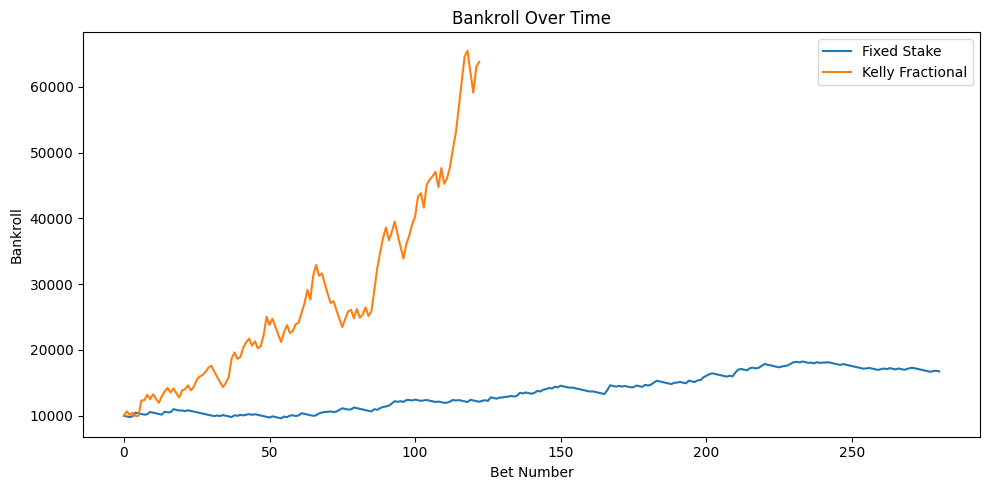

In [3]:
equity_fixed, equity_kelly, bets_with_stakes, roi_results, value_bets_df = bets_simulations(calibrated_model,
                                                                                            X_test_last, test_indexed)
print_simulation_report(equity_fixed, equity_kelly, bets_with_stakes, roi_results)
plot_bankroll_over_time(equity_fixed, equity_kelly)

Fixed Stake: Starting bankroll of 10,000 grows to 16,738$ with a max drawdown of 8.6% and a Sharpe ratio of 2.30.

Fractional Kelly: Starting bankroll of 10,000 grows to 63,781$ with a max drawdown of 28.6% and Sharpe ratio of 4.72.

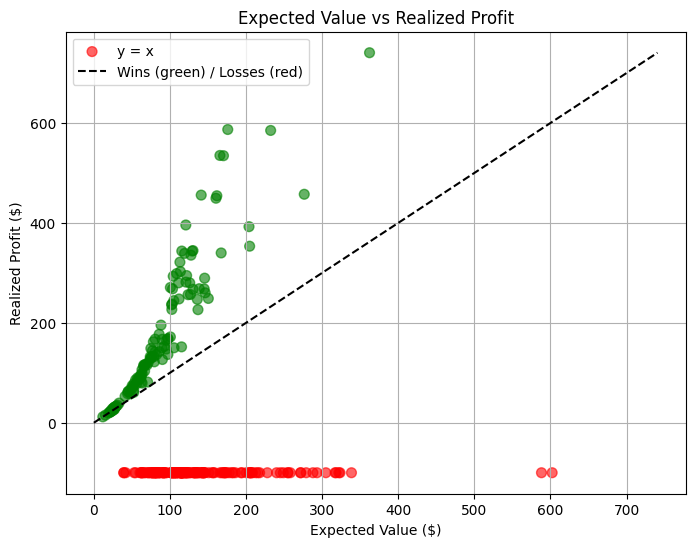

In [4]:
plot_ev_vs_profit(bets_with_stakes)

These results confirm that even modest predictive accuracy can be translated into substantial financial gains when combined with edge-based staking strategies.

3. Market Inefficiency Discovery

Analysis reveals systematic market biases:

In [5]:
analyze_market_performance(prepare_features.label_encoder, clean_data)



 Market Performance Analysis:

   Feature order: ['Market_Prob_Away', 'Market_Prob_Draw', 'Market_Prob_Home']
   Label encoding: [('A', 0), ('D', 1), ('H', 2)]
   Market predictions: H=2986, D=0, A=1574
   Actual results: H=2053, D=1072, A=1435
   Market accuracy when predicting A: 0.535
   Market accuracy when predicting H: 0.565
   First 5 games market probabilities [Away, Draw, Home]:
   Game 0: Probs[A=0.112, D=0.211, H=0.678] -> Pred: H, Actual: D
   Game 1: Probs[A=0.211, D=0.263, H=0.526] -> Pred: H, Actual: H
   Game 2: Probs[A=0.344, D=0.278, H=0.378] -> Pred: H, Actual: H
   Game 3: Probs[A=0.249, D=0.278, H=0.473] -> Pred: H, Actual: A
   Game 4: Probs[A=0.307, D=0.293, H=0.400] -> Pred: H, Actual: D

Draw Prediction Analysis:
   Draw predictions: 0/4560 (0.0%)
   Average draw probability: 0.243
   Maximum draw probability: 0.339
   Games with draw prob > 0.4: 0
   Games with draw prob > 0.5: 0



Underprediction of draws: Market predicted 0 draws out of 4,560 matches.

Maximum market draw probability: 33.9%

4. Probability Calibration

Calibrated probabilities allow for more accurate edge calculation and improved value-bet identification. Bootstrap resampling confirms the statistical significance of these results:

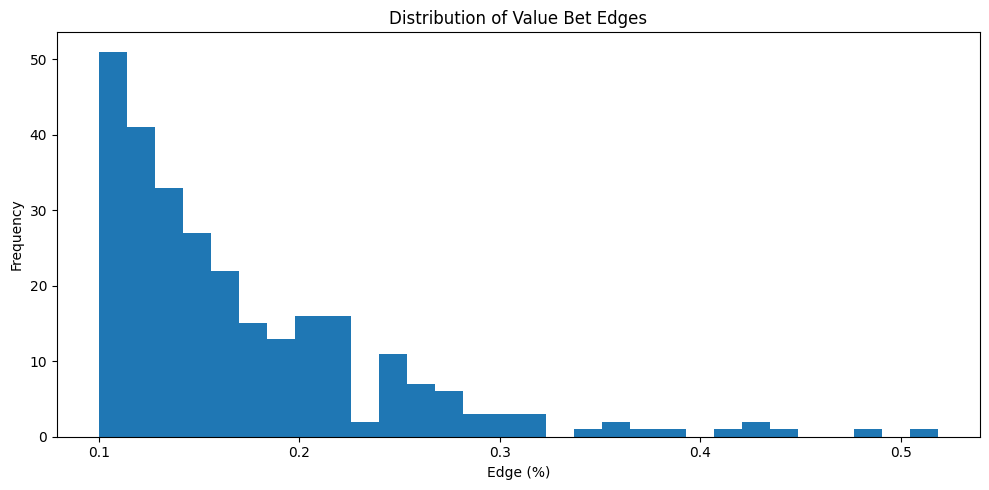

In [6]:
plot_edge_distribution(value_bets_df)

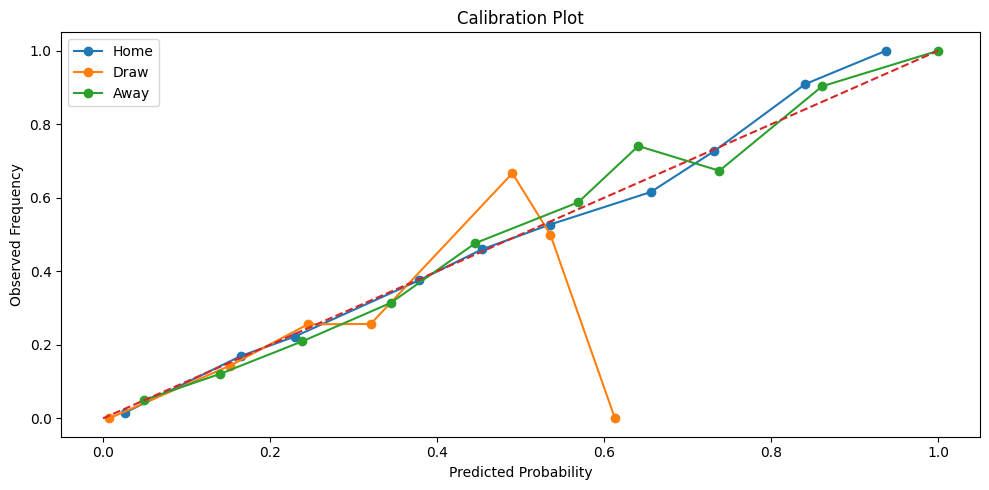

In [7]:
plot_calibration_curve(calibrated_model, X_test_last, y_test_last, ["Home", "Draw", "Away"])

The model slightly overestimates the probability of a draw, while at higher predicted probabilities (~60%), it underestimates the true likelihood. This indicates that while the model is generally well-calibrated, there is room for adjustment at the higher probability range to improve edge detection and value betting accuracy.

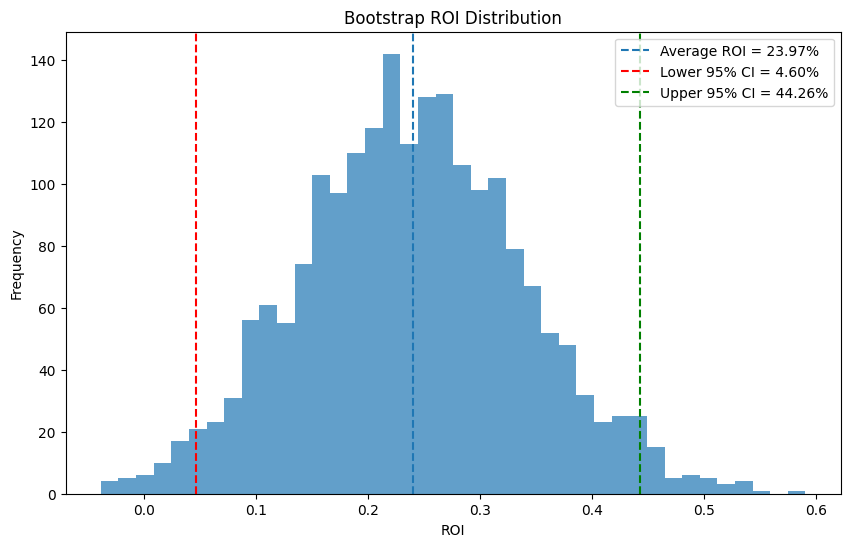

In [8]:
plot_bootstrap_roi_distribution(roi_results)

The positive lower bound demonstrates that profitability is unlikely to be due to chance.

5. Risk Assessment

Risk metrics indicate favorable risk-adjusted returns:

* Sharpe Ratios: 2.30 (Fixed Stake) and 4.72 (Fractional Kelly)
* Maximum Drawdowns: 8.6% (Fixed) and 28.6% (Kelly)

These values confirm that the proposed strategies are economically robust and manageable from a risk perspective.

6. The Accuracy-Edge Paradox

This research identifies a critical paradox:

Traditional View: Higher prediction accuracy leads to better economic returns.

Discovery: In efficient markets, marginal accuracy improvements are difficult, but substantial economic value can be extracted through:

* Superior probability calibration
* Systematic edge identification
* Optimal bet sizing strategies

7. Limitations and Future Research

* Single Market Focus: Results based on Premier League only.
* Historical Data: Real-time implementation effects remain untested.
* Sample Size: Limited number of value bets (n=280)

Future research directions include:

* Cross-league validation across different football competitions.
* Real-time implementation using dynamic odds.
* Advanced feature engineering incorporating player-level and situational data.
* Market impact analysis of widespread strategy adoption.

 8. Conclusion

This work explored whether machine learning models are capable of identifying and exploiting systematic mispricings in Premier League betting markets.

Our findings support this hypothesis. The best-performing model, XGBoost, achieved 54.8% raw accuracy, compared to the market baseline of 55.4%. However, accuracy alone did not determine profitability. Instead, the model consistently identified value opportunities - particularly in matches where market underestimates the likelihood of a draw. Through probability calibration, edge estimation, and optimal bet-sizing techniques, these insights translated into substantial positive returns.

Boostrap resampling further validated these results, demonstrating that the observed profitability is statistically significant and not attributable to a random chance.

These results also help us better understand how efficient the betting market really is. While EPL betting markets appear reasonably efficient in predicting overall match outcomes, they exhibit persistent structural biases, especially against draw. Such inefficiencies create repeatable opportunities for informed bettors, showing that machine learning can generate economic value even without outperforming the market in prediction accuracy.

Overall, this study contributes both to academic discussions of prediction-market efficiency and to practical betting-strategy design. It demonstrates that machine learning, when combined with calibration and value-focused decision frameworks, can uncover market mispricing and deliver profitable, data-driven betting strategies.

9. Final Verdict

The results clearly confirm the core hypothesis. Machine learning models are able to detect persistent mispricings in Premier League betting markets, particularly around draw outcomes, and convert them into profitable value-based strategies. This demonstrates that the market is not fully efficient and that ML methods offer a measurable and repeatable advantage.